In [ ]:
# use env ../speedPy.yml
import pylab
import matplotlib.pyplot as plt
import timeit
from utils import *
import numpy as np
global_params = {
    'text.usetex' : False,
    'font.family' : 'serif',
    'font.sans-serif' : ['Helvetica'],
    'ps.usedistiller' : 'xpdf',
    'ps.distiller.res' : 3000,
    'axes.labelsize' : 13,
          #'text.fontsize' : 16,
    'legend.fontsize' : 10,
    'xtick.labelsize' : 12,
    'ytick.labelsize' : 12,
    'axes.linewidth': 2.0,
    'axes.grid':True,  
    'figure.figsize' : [7,5],
    'grid.linestyle':'--',
    'grid.color':'k',
    'grid.alpha':0.2}
pylab.rcParams.update(global_params) 

## Simple Math Loops

I want to compute 100,000 integrals of 
$$
\int_0^1{\left(1+x\right)^a}
$$. 
How can I do this the fastest?

In [2]:
np.random.seed(42)
def slow_integral(a): #going to do a simple sum to approximate
    resolution=1000 #number of rectangles
    grid=np.linspace(0,1,resolution)
    result=0
    for point in grid:
        result+= ((1+point)**a) * (1/resolution)
    return result
def faster_integral(a): #some numpy magic
    resolution=1000 #number of rectangles
    grid=np.linspace(0,1,resolution)
    result=((1+grid)**a)* (1/resolution)
    return result.sum()

First lets test the performance of a single evaluation

In [3]:
%timeit slow_integral(2)
%timeit faster_integral(2)

571 μs ± 1.56 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
23.7 μs ± 103 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


We can see that using the numpy arithmatic is much faster per evaluation.

### Single Thread options
In the following section I'll test different ways to compute this function 100,000 times but only use single threads (at least not explicitly ask for multiple threads)

In [4]:
np.random.seed(42)
test_numbers=np.random.uniform(-5,5,size=100000)
def simple_loop_append(vals): #do a simple loop and append to the list
    results=[]
    for val in vals:
        results.append(faster_integral(val))
    return results
def simple_loop_index(vals): #do a simple loop and index result to the list
    results=np.ones(len(vals))
    for i,val in enumerate(vals):
        results[i]=faster_integral(val)
    return results
def list_loop(vals):
    return [faster_integral(val) for val in vals]

numpy_vectorized=np.vectorize(faster_integral)

In [5]:
simple_loop_append_timer=timeit.Timer('simple_loop_append(test_numbers)',globals=globals())
simple_loop_append_results=simple_loop_append_timer.repeat(10,number=1)

simple_loop_index_timer=timeit.Timer('simple_loop_index(test_numbers)',globals=globals())
simple_loop_index_results=simple_loop_index_timer.repeat(10,number=1)

list_loop_timer=timeit.Timer('list_loop(test_numbers)',globals=globals())
list_loop_results=list_loop_timer.repeat(10,number=1)

numpy_vectorized_timer=timeit.Timer('numpy_vectorized(test_numbers)',globals=globals())
numpy_vectorized_results=numpy_vectorized_timer.repeat(10,number=1)


In [6]:
summary('simple_loop_append',simple_loop_append_results)
summary('simple_loop_index',simple_loop_index_results)
summary('list_loop',list_loop_results)
summary('numpy_vectorized',numpy_vectorized_results)

simple_loop_append 10 runs: 
 Mean 4.1657924541985265 
 Standard deviation 0.00931587204489269
simple_loop_index 10 runs: 
 Mean 4.18478748330017 
 Standard deviation 0.003739483564177131
list_loop 10 runs: 
 Mean 4.181876879298943 
 Standard deviation 0.06864016882676725
numpy_vectorized 10 runs: 
 Mean 4.1675610667 
 Standard deviation 0.01807252211373919


Almost no difference

## MultiProccesing

Lets just start with the basic built in multi threading and compare to the fastest execution from above.

In [ ]:
from utils import built_in_threads,built_in_process 
#Processes can not use local variables so these functions are defined in ./utils.py
built_in_threads_timer=timeit.Timer('built_in_threads(test_numbers)',globals=globals())
built_in_threads_results=built_in_threads_timer.repeat(10,number=1)
built_in_process_timer=timeit.Timer('built_in_process(test_numbers)',globals=globals())
built_in_process_results=built_in_process_timer.repeat(10,number=1)

In [8]:
summary('built_in_threads',built_in_threads_results)
summary('built_in_process',built_in_process_results)

built_in_threads 10 runs: 
 Mean 5.17175732919859 
 Standard deviation 0.4437179929789269
built_in_process 10 runs: 
 Mean 2.1493349041011243 
 Standard deviation 0.10604084625033017


#### Useing a process is much faster than using threads.
How do these scale with the number of thread/processes spawned?

In [ ]:
number_of_threads=[i for i in range(1,9)]
p_results=[]
t_results=[]
for i in number_of_threads:
    t=timeit.Timer(f'built_in_process(test_numbers,n_threads={i})',globals=globals()).repeat(3,number=1)
    t=np.array(t)
    p_results.append([t.mean(),t.std()])

    t=timeit.Timer(f'built_in_threads(test_numbers,n_threads={i})',globals=globals()).repeat(3,number=1)
    t=np.array(t)
    t_results.append([t.mean(),t.std()])

The best number of Processes was 4


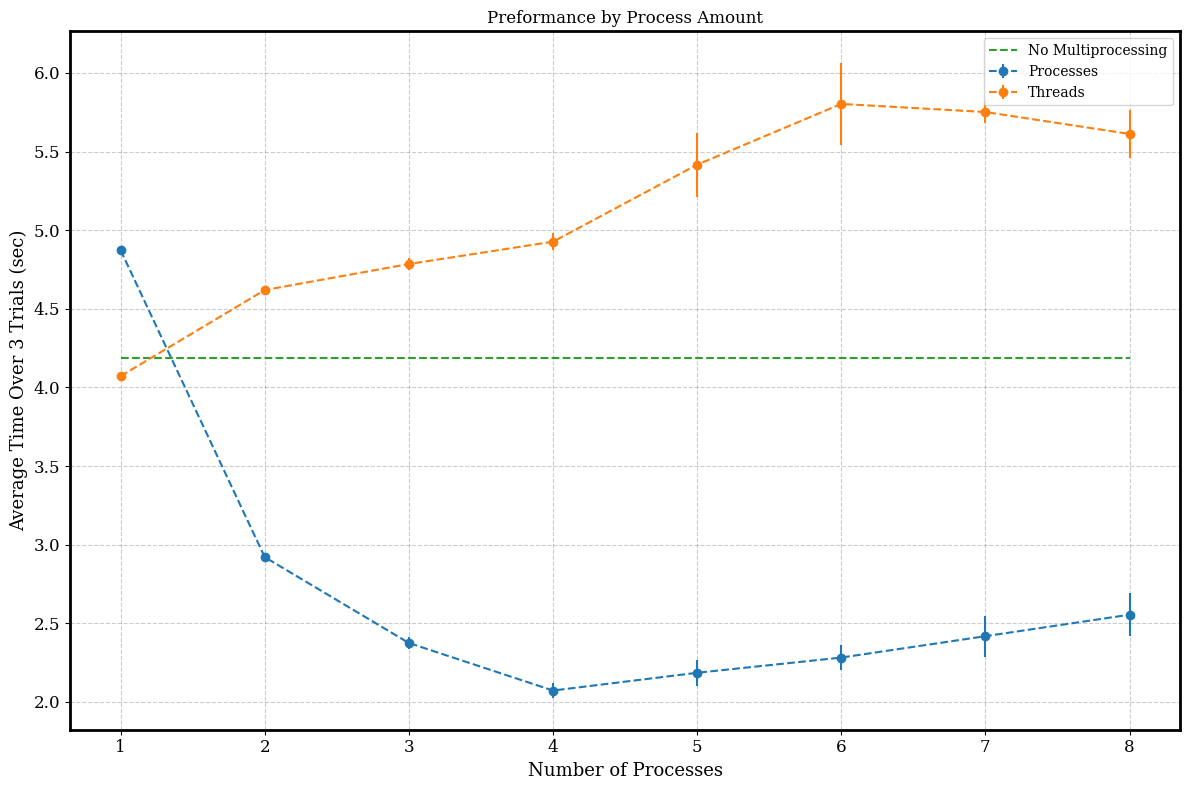

In [10]:
p_results=np.array(p_results)
t_results=np.array(t_results)
fig,ax=plt.subplots(figsize=(12,8))
min_p=number_of_threads[np.argmin(p_results[:,0])]
min_t=number_of_threads[np.argmin(t_results[:,0])]
_=ax.errorbar(x=number_of_threads,y=p_results[:,0],yerr=p_results[:,1],linestyle='--',marker='o',label='Processes')
_=ax.errorbar(x=number_of_threads,y=t_results[:,0],yerr=t_results[:,1],linestyle='--',marker='o',label='Threads')
_=ax.plot(np.linspace(1,8,100),np.ones(100)*np.mean(simple_loop_index_results),label='No Multiprocessing',marker=None,linestyle='--')
_=ax.set_title('Preformance by Process Amount')
_=ax.set_ylabel('Average Time Over 3 Trials (sec)')
_=ax.set_xlabel('Number of Processes')
_=ax.legend()
plt.tight_layout()
print(f'The best number of Processes was {min_p}')

## Thread vs Process
Why is using threads so bad? Python has a Global Interpreter Lock (GIL), this limits python to only use one interpreter at a time. This was implemented to let python manage memory for you easily. However this means that python does not run multiple threads at the same time! Only one thread goes at a time!!! If the interpreter needs to do work threads will not help. On the other hand proceses spawn new intrepeters so they can actully run in parralel!! Proceses do not share memory so it can be difficult to cordinate them, but the speed is worth it!

This is the best I can do with the built in python libraries. Can I beat other packages?

In [ ]:
from joblib import Parallel, delayed
joblib_results =timeit.Timer(f'Parallel(n_jobs=7)(delayed(faster_integral)(a) for a in test_numbers)',globals=globals()).repeat(5,number=1)

In [12]:
summary('joblib',joblib_results)

joblib 5 runs: 
 Mean 1.807864208202227 
 Standard deviation 0.9322900431598147


In [ ]:
number_of_threads=[i for i in range(1,9)]
p_results=[]
jl_results=[]
for i in number_of_threads:
    t=timeit.Timer(f'built_in_process(test_numbers,n_threads={i})',globals=globals()).repeat(3,number=1)
    t=np.array(t)
    p_results.append([t.mean(),t.std()])

    t=timeit.Timer(f'Parallel(n_jobs={i})(delayed(faster_integral)(a) for a in test_numbers)',globals=globals()).repeat(3,number=1)
    t=np.array(t)
    jl_results.append([t.mean(),t.std()])

The best number for Processes was 4
The best number for Joblib was 7


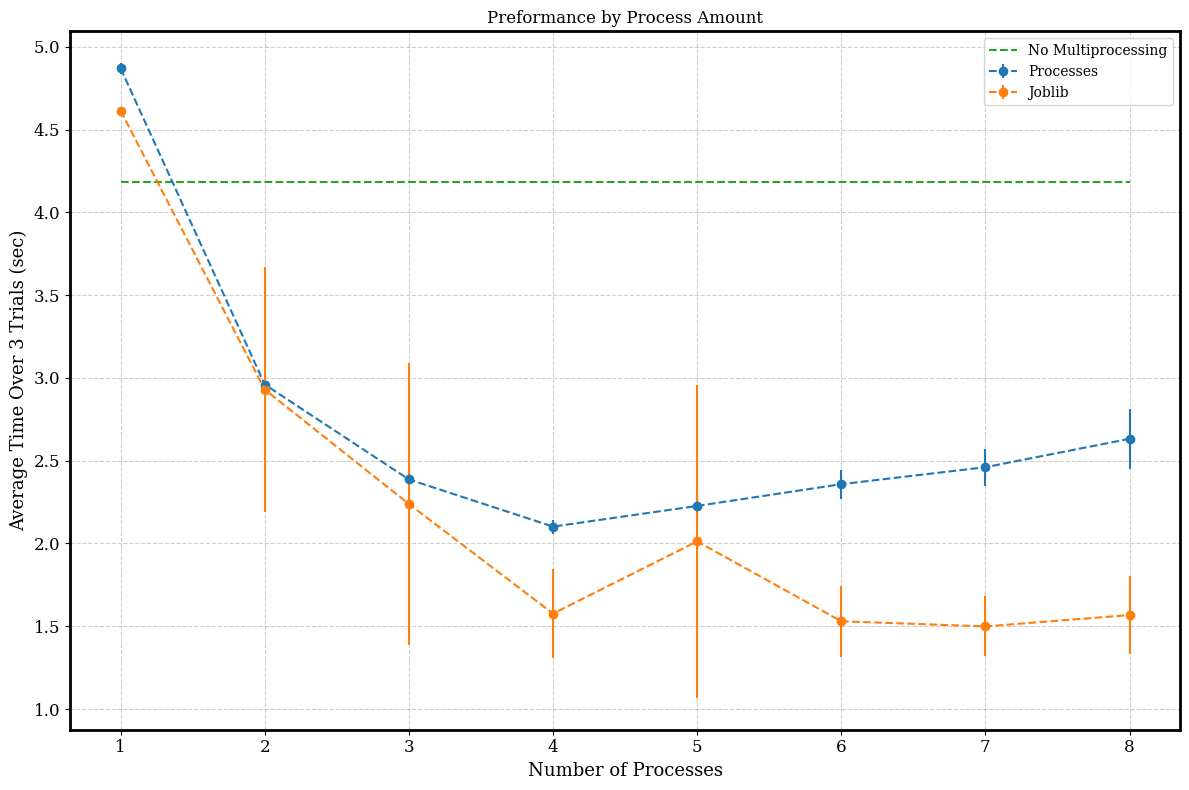

In [14]:
p_results=np.array(p_results)
jl_results=np.array(jl_results)
fig,ax=plt.subplots(figsize=(12,8))
min_p=number_of_threads[np.argmin(p_results[:,0])]
min_jl=number_of_threads[np.argmin(jl_results[:,0])]
_=ax.errorbar(x=number_of_threads,y=p_results[:,0],yerr=p_results[:,1],linestyle='--',marker='o',label='Processes')
_=ax.errorbar(x=number_of_threads,y=jl_results[:,0],yerr=jl_results[:,1],linestyle='--',marker='o',label='Joblib')
_=ax.plot(np.linspace(1,8,100),np.ones(100)*np.mean(simple_loop_index_results),label='No Multiprocessing',marker=None,linestyle='--')
_=ax.set_title('Preformance by Process Amount')
_=ax.set_ylabel('Average Time Over 3 Trials (sec)')
_=ax.set_xlabel('Number of Processes')
_=ax.legend()
plt.tight_layout()
print(f'The best number for Processes was {min_p}')
print(f'The best number for Joblib was {min_jl}')

Id say this is comparable. I wrote the decorator future_dec in utils.py to make any of your python code do multiprocessing.